In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = r'C:\Users\dell\OneDrive\Desktop\Projects\flickr8k'
WORKING_DIR = r'C:\Users\dell\OneDrive\Desktop\Projects\flickr8k\working'
os.makedirs(WORKING_DIR, exist_ok=True)

In [3]:
# load vgg16 model
model = VGG16()
#Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
import os
import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

# Function to preprocess a single image
def preprocess_image(img_path):
    # Load the image
    image = load_img(img_path, target_size=(224, 224))
    # Convert image to numpy array
    image = img_to_array(image)
    # Add batch dimension (reshape)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image
    return preprocess_input(image)

# Directory and file paths
features_file = os.path.join(WORKING_DIR, 'features.pkl')  # Path to store features
directory = os.path.join(BASE_DIR, 'Images')  # Ensure 'Images' exists in BASE_DIR

if not os.path.exists(directory):
    raise FileNotFoundError(f"Directory not found: {directory}")

# Check if features are already saved
if os.path.exists(features_file):
    print("Loading features from pickle file...")
    with open(features_file, 'rb') as f:
        features = pickle.load(f)
    print("Features loaded successfully.")
else:
    print("Processing images to extract features...")
    features = {}

    # Iterate through images
    for img_name in tqdm(os.listdir(directory), desc="Processing images"):
        img_path = os.path.join(directory, img_name)
        
        try:
            # Preprocess the image
            image = preprocess_image(img_path)
            # Extract features
            feature = model.predict(image, verbose=0)
            # Get image ID
            image_id = img_name.split('.')[0]
            # Store features
            features[image_id] = feature
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

    # Save the features to a pickle file
    print("Saving features to pickle file...")
    with open(features_file, 'wb') as f:
        pickle.dump(features, f)
    print("Features saved successfully.")


Loading features from pickle file...
Features loaded successfully.


In [5]:
#store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    featues = pickle.load(f)

Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
#create mapping of image to captions
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #remove extension from image ID
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = " ".join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    #store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 194233.11it/s]


In [9]:
len(mapping)

8091

In [10]:
import re  # Import the regex module

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove digits, special characters, etc.
            caption = re.sub(r'[^a-zA-Z\s]', '', caption)
            # Remove additional spaces
            caption = re.sub(r'\s+', ' ', caption).strip()
            # Filter out short words and add start/end tags
            words = [word for word in caption.split() if len(word) > 1]
            if words:  # Only update if valid words remain
                caption = '<start> ' + " ".join(words) + ' <end>'
                captions[i] = caption
            else:
                captions[i] = ''  # Or handle as needed (e.g., remove invalid captions)


In [11]:
#before preprocess of text
mapping['667626_18933d713e']

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 '"A young girl is lying in the sand   while ocean water is surrounding her ."',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [12]:
#preprocess the text
clean(mapping)

In [13]:
#after preprocess of text
mapping['667626_18933d713e']

['<start> girl is stretched out in shallow water <end>',
 '<start> girl wearing red and multicolored bikini is laying on her back in shallow water <end>',
 '<start> little girl in red swimsuit is laying on her back in shallow water <end>',
 '<start> young girl is lying in the sand while ocean water is surrounding her <end>',
 '<start> girl wearing bikini lying on her back in shallow pool of clear blue water <end>']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tricolored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [17]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8766

In [19]:
#get maximum length of caption availble
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)  # Multiply by 0.90 to get the 90% split
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

In [22]:
!pip install pydot --upgrade



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
!pip install graphviz pydot --upgrade



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


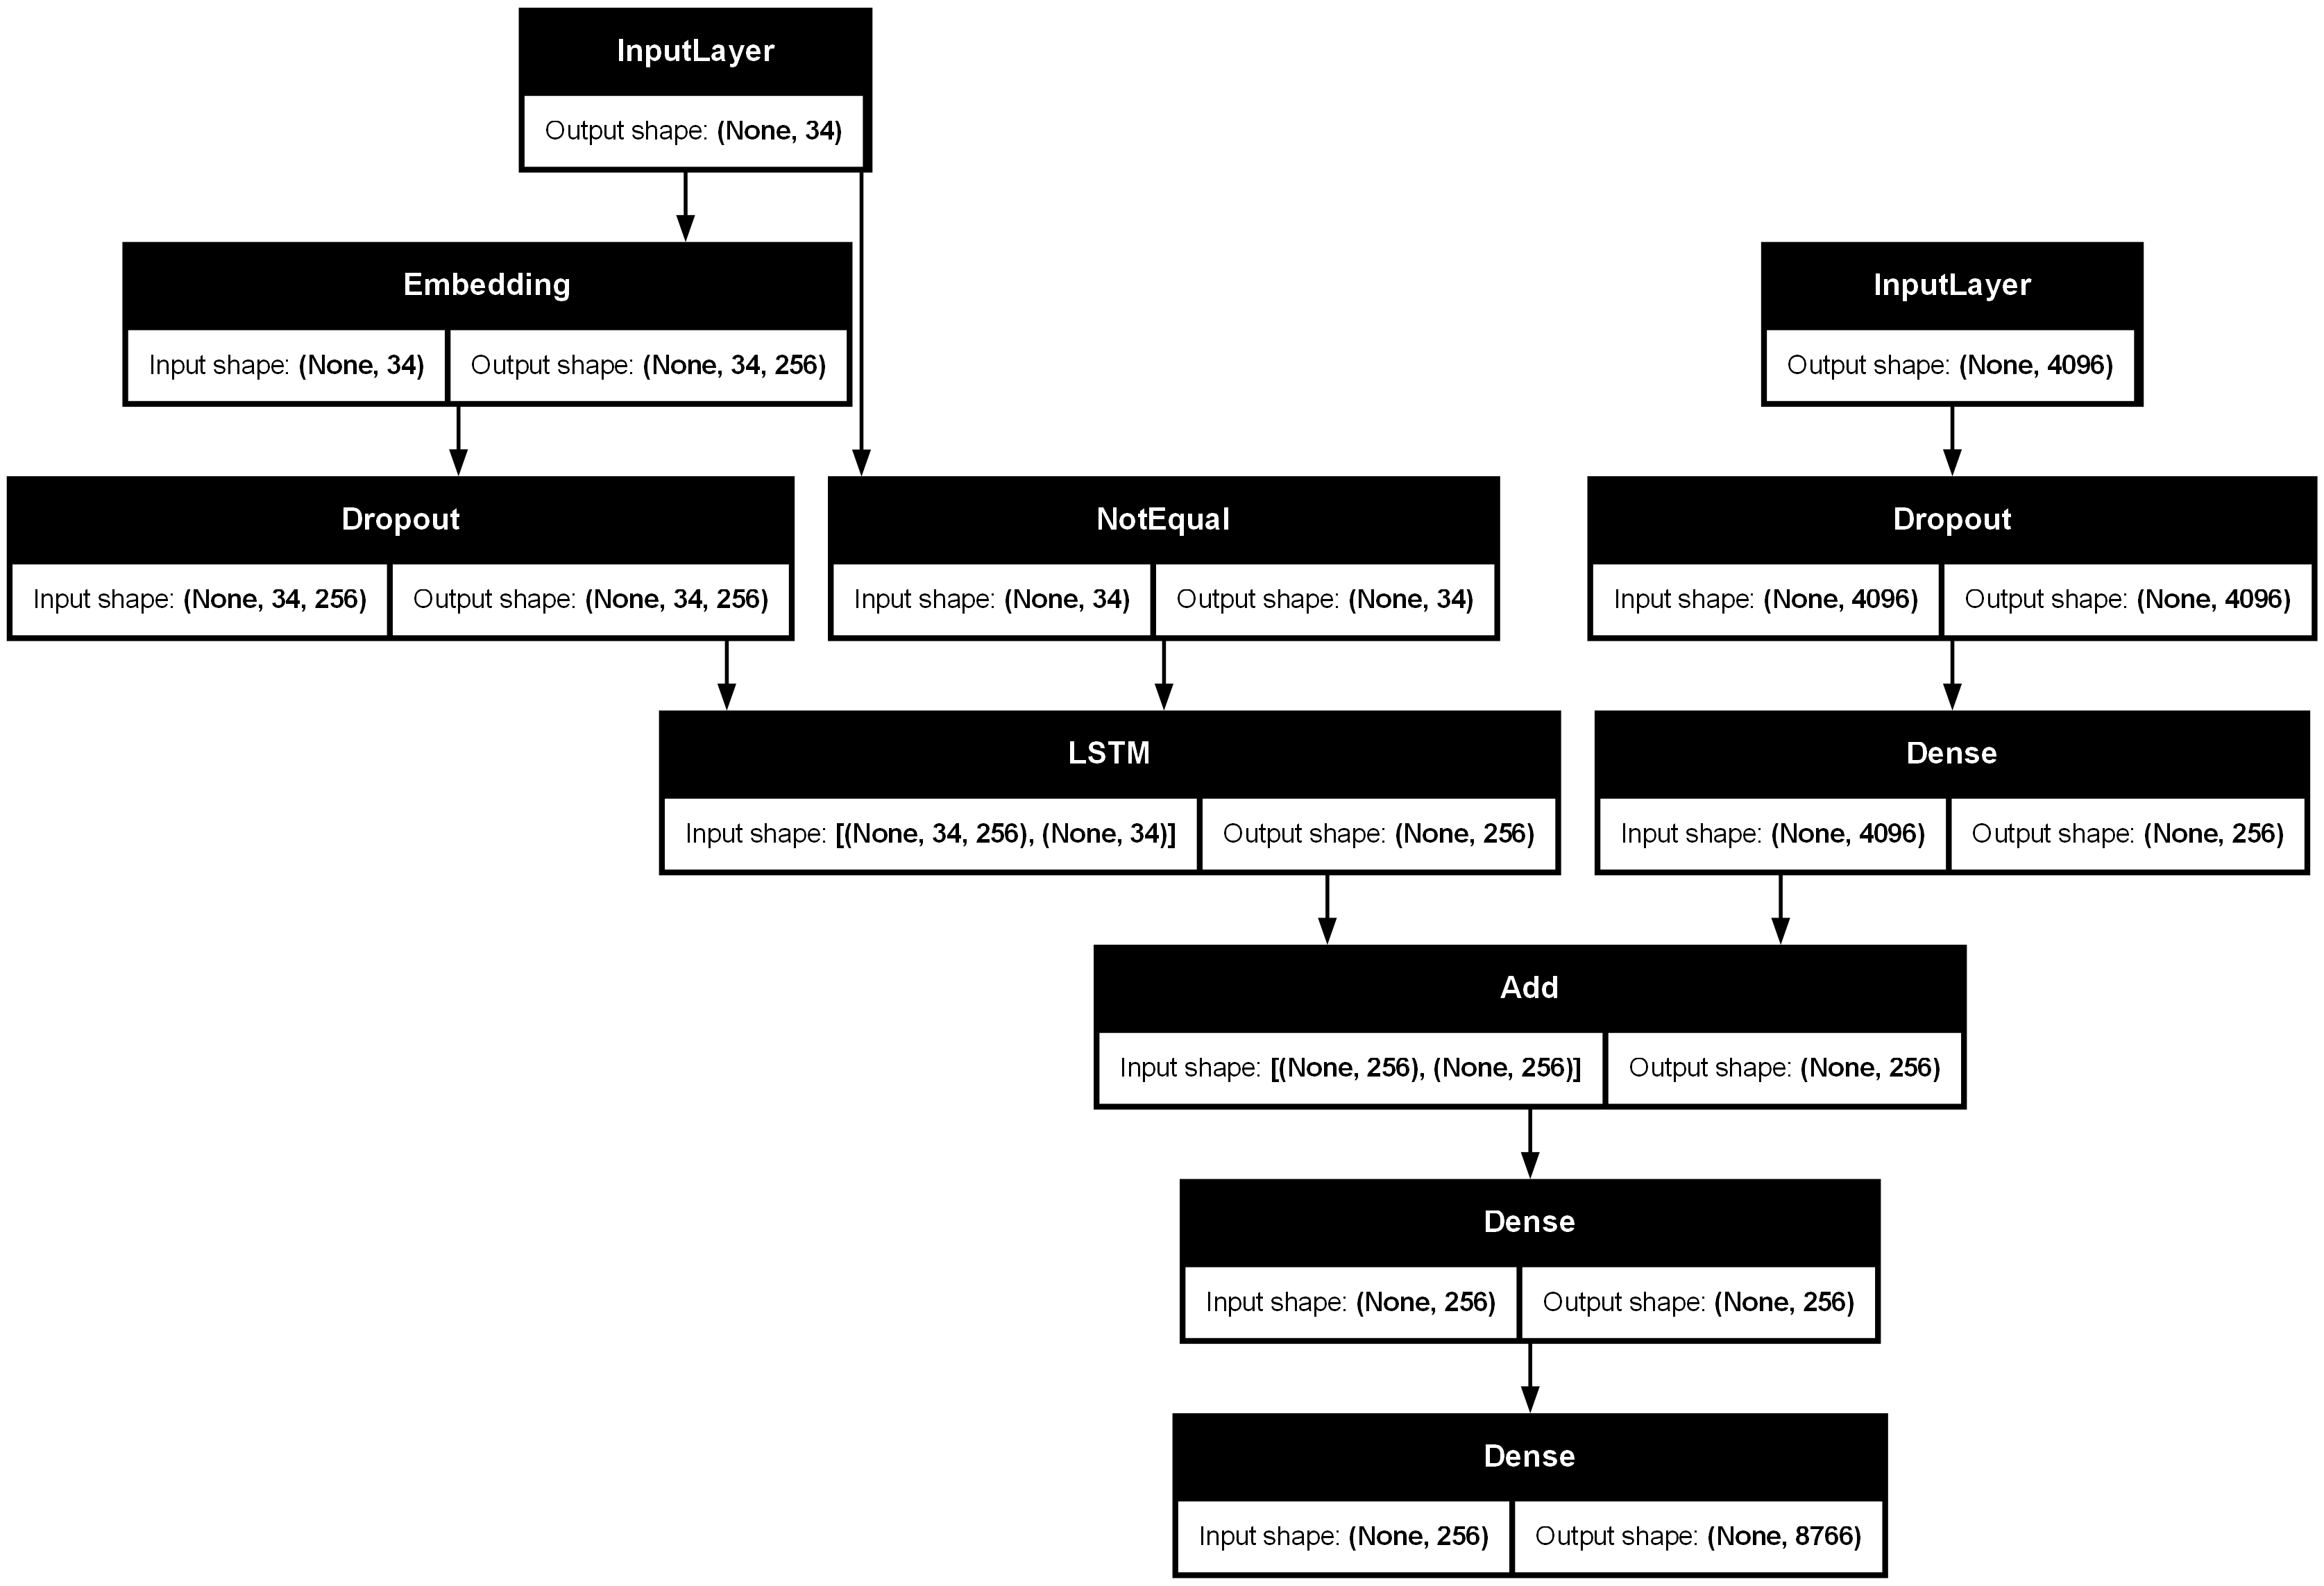

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [25]:
import os
from tensorflow.keras.models import load_model

# Define the model file name
model_file = 'best_model.keras'

# Check if the model is already saved
if os.path.exists(model_file):
    print(f"Loading the model from {model_file}")
    model = load_model(model_file)
else:
    print("Training the model...")
    epochs = 15
    batch_size = 64
    steps = len(train) // batch_size

    for i in range(epochs):
        # Create data generator
        generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        # Fit for one epoch
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
    # Save the trained model
    model.save(model_file)
    print(f"Model saved as {model_file}")


Loading the model from best_model.keras


In [26]:
#save the model
model.save('best_model.keras')


Generate Captions for the Image

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
pip install --upgrade nltk


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
pip install sacrebleu


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [1:55:30<00:00,  8.56s/it]    


BLEU-1: 0.110653
BLEU-2: 0.058130


Visualize the Results


In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
<start> child in pink dress is climbing up set of stairs in an entry way <end>
<start> girl going into wooden building <end>
<start> little girl climbing into wooden playhouse <end>
<start> little girl climbing the stairs to her playhouse <end>
<start> little girl in pink dress going into wooden cabin <end>
--------------------Predicted--------------------
startseq playhouse the table is sitting on wooden table in the middle of wooden table end of wooden table end end of wooden table end end of wooden table end end of wooden table end


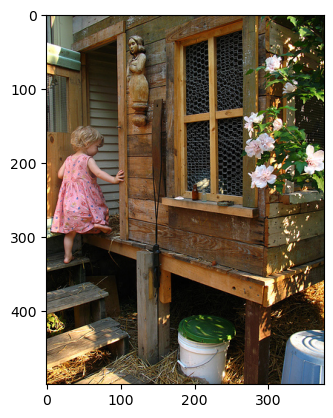

In [33]:
generate_caption("1000268201_693b08cb0e.jpg")